In [27]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
from matplotlib.pyplot import * 
from PIL import Image

In [28]:
import torch
from torchvision import datasets, transforms as T
import torchvision
import time
import copy
import os

In [29]:
squeezenet = models.squeezenet1_0(pretrained=True)
squeezenet.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1,1), stride=(1,1))

In [30]:
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64

data_dir = './New Masks Dataset/Face Mask Dataset'
MODEL_STORE_PATH = './'
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
    'faces': transforms.Compose([
#         transforms.RandomResizedCrop(64),
        transforms.Resize(64, interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
}
def get_dataset(data_dir, data_transforms ):
    # create train and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    #get classes from train dataset folders name
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes
train_dataloader, test_dataloader , classes, dataset_sizes=get_dataset(data_dir,data_transforms)
print('Classes: ',  classes)

Classes:  ['WithMask', 'WithoutMask']


In [34]:
train_dataloader

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(squeezenet.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

#num_ftrs = squeezenet.fc.in_features
#squeezenet.fc = nn.Linear(num_ftrs, 128)
net = squeezenet.cuda()

In [9]:
n_epochs = 5
x = 0
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        
        if network_learned:
            if correct_t/total_t>x:
                x = correct_t/total_t
                valid_loss_min = batch_loss
                torch.save(net.state_dict(), 'sq.pt')
                print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/5], Step [0/2211], Loss: 0.4902
Epoch [1/5], Step [20/2211], Loss: 0.0130
Epoch [1/5], Step [40/2211], Loss: 0.0000
Epoch [1/5], Step [60/2211], Loss: 0.0000
Epoch [1/5], Step [80/2211], Loss: 0.0000
Epoch [1/5], Step [100/2211], Loss: 0.0000
Epoch [1/5], Step [120/2211], Loss: 0.0000
Epoch [1/5], Step [140/2211], Loss: 0.0000
Epoch [1/5], Step [160/2211], Loss: 0.0000
Epoch [1/5], Step [180/2211], Loss: 0.0000
Epoch [1/5], Step [200/2211], Loss: 0.0000
Epoch [1/5], Step [220/2211], Loss: 0.0000
Epoch [1/5], Step [240/2211], Loss: 0.0000
Epoch [1/5], Step [260/2211], Loss: 0.0004
Epoch [1/5], Step [280/2211], Loss: 0.0000
Epoch [1/5], Step [300/2211], Loss: 0.0000
Epoch [1/5], Step [320/2211], Loss: 0.0004
Epoch [1/5], Step [340/2211], Loss: 0.0000
Epoch [1/5], Step [360/2211], Loss: 0.0000
Epoch [1/5], Step [380/2211], Loss: 0.0000
Epoch [1/5], Step [400/2211], Loss: 0.0000
Epoch [1/5], Step [420/2211], Loss: 0.0000
Epoch [1/5], Step [440/2211], Loss: 0.0000
Epoch [1

Epoch [2/5], Step [1500/2211], Loss: 0.0000
Epoch [2/5], Step [1520/2211], Loss: 0.0000
Epoch [2/5], Step [1540/2211], Loss: 0.0000
Epoch [2/5], Step [1560/2211], Loss: 0.0000
Epoch [2/5], Step [1580/2211], Loss: 0.0000
Epoch [2/5], Step [1600/2211], Loss: 0.0000
Epoch [2/5], Step [1620/2211], Loss: 0.0000
Epoch [2/5], Step [1640/2211], Loss: 0.0000
Epoch [2/5], Step [1660/2211], Loss: 0.0000
Epoch [2/5], Step [1680/2211], Loss: 0.0000
Epoch [2/5], Step [1700/2211], Loss: 0.0000
Epoch [2/5], Step [1720/2211], Loss: 0.0000
Epoch [2/5], Step [1740/2211], Loss: 0.0000
Epoch [2/5], Step [1760/2211], Loss: 0.0000
Epoch [2/5], Step [1780/2211], Loss: 0.0000
Epoch [2/5], Step [1800/2211], Loss: 0.0000
Epoch [2/5], Step [1820/2211], Loss: 0.0000
Epoch [2/5], Step [1840/2211], Loss: 0.0000
Epoch [2/5], Step [1860/2211], Loss: 0.0000
Epoch [2/5], Step [1880/2211], Loss: 0.0000
Epoch [2/5], Step [1900/2211], Loss: 0.0000
Epoch [2/5], Step [1920/2211], Loss: 0.0000
Epoch [2/5], Step [1940/2211], L

Epoch [4/5], Step [740/2211], Loss: 0.0000
Epoch [4/5], Step [760/2211], Loss: 0.0000
Epoch [4/5], Step [780/2211], Loss: 0.0000
Epoch [4/5], Step [800/2211], Loss: 0.0000
Epoch [4/5], Step [820/2211], Loss: 0.0000
Epoch [4/5], Step [840/2211], Loss: 0.0000
Epoch [4/5], Step [860/2211], Loss: 0.0000
Epoch [4/5], Step [880/2211], Loss: 0.0000
Epoch [4/5], Step [900/2211], Loss: 0.0000
Epoch [4/5], Step [920/2211], Loss: 0.0000
Epoch [4/5], Step [940/2211], Loss: 0.0000
Epoch [4/5], Step [960/2211], Loss: 0.0000
Epoch [4/5], Step [980/2211], Loss: 0.0000
Epoch [4/5], Step [1000/2211], Loss: 0.0000
Epoch [4/5], Step [1020/2211], Loss: 0.0000
Epoch [4/5], Step [1040/2211], Loss: 0.0000
Epoch [4/5], Step [1060/2211], Loss: 0.0000
Epoch [4/5], Step [1080/2211], Loss: 0.0000
Epoch [4/5], Step [1100/2211], Loss: 0.0000
Epoch [4/5], Step [1120/2211], Loss: 0.0000
Epoch [4/5], Step [1140/2211], Loss: 0.0000
Epoch [4/5], Step [1160/2211], Loss: 0.0000
Epoch [4/5], Step [1180/2211], Loss: 0.0000
E

validation loss: 20.2891, validation acc: 48.6895



In [10]:
import matplotlib.pyplot as plt

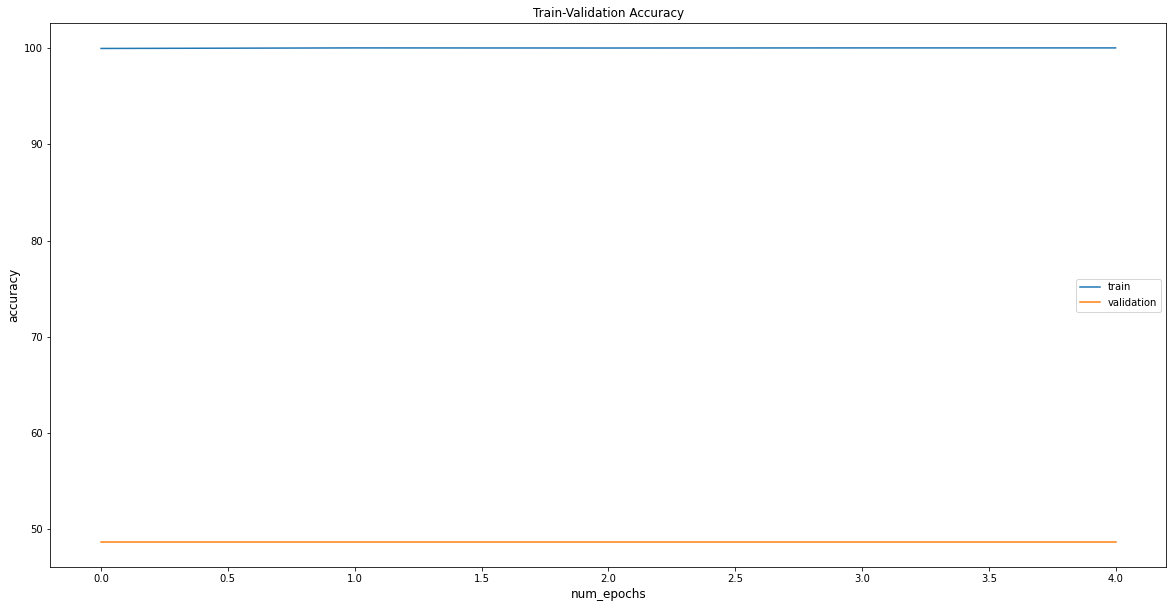

In [11]:
ig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [12]:
net.load_state_dict(torch.load('sq.pt'))
trans = torchvision.transforms.Compose(
[
    torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

test_dataset = torchvision.datasets.ImageFolder(root='./New Masks Dataset/Face Mask Dataset/Validation', transform=trans)

In [13]:
data_dir_valid = './New Masks Dataset/Face Mask Dataset/Validation'
MODEL_STORE_PATH = './'
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(64, interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(64, interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
}

train_dataloader1, test_dataloader1 , classes1, dataset_sizes1=get_dataset(data_dir,data_transforms)
print('Classes: ',  classes1)

Classes:  ['WithMask', 'WithoutMask']


In [26]:
from torch.utils.data import Dataset
use_cuda = True
import time
TPR =[]
FPR = []
dataLable = []
predict = []

inp = []
out = []
def model_metric(net):
    alls = 0
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    j=0
    time1 = 0
    batch =4 
    loss = 0
    for i, data in enumerate(train_dataloader1):
        j+=batch
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
            if inputs.shape[0]!= batch:
                continue
        start_time = time.time()
        outputs = net(inputs)
        time1 +=(time.time() - start_time)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if use_cuda else preds.numpy()
        
        for j in range(0,batch-1):
            inp.append(labels[j])
            out.append(preds[j])
            if ((labels[j] == preds[j]) and (preds[j] == 1)) : tp+=1
            if ((labels[j] != preds[j]) and (preds[j] == 1)): fp+=1
            if ((labels[j] != preds[j]) and (preds[j] == 0)): fn+=1
            if ((labels[j] == preds[j]) and (preds[j] == 0)): tn+=1
            dataLable.append(labels[j])
            predict.append(preds[j])
                
    #recall = (tp)/(tp+fn)
    #precision = (tp)/(tp+fp)
    #f1 = 2*((precision*recall)/(precision+recall))
    print("False Negative = ",fn)
    #print("Recall =",recall )
    #print("Precision =",precision )
    #print("f1 =", f1 )
    print("Time predict =", time1/j )

    print("all param = ",sum(p.numel() for p in net.parameters()))
    print("learn param = ",sum(p.numel() for p in net.parameters() if p.requires_grad))
    loss = F.binary_cross_entropy(F.sigmoid(torch.Tensor(inp)),torch.Tensor(out))
    print("LogLoss = ",loss)

model_metric(net)

False Negative =  0
Time predict = 1.337302843729655
all param =  736450
learn param =  736450
LogLoss =  tensor(0.6931)


C:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [22]:
torch.Size([2, 3, 64, 64])[0]

2

In [ ]:
loss = F.binary_cross_entropy(F.sigmoid(torch.Tensor(inp)),torch.Tensor(out))
print("LogLoss = ",loss)

In [81]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(np.array(dataLable), np.array(predict))
roc_auc = metrics.auc(fpr, tpr)

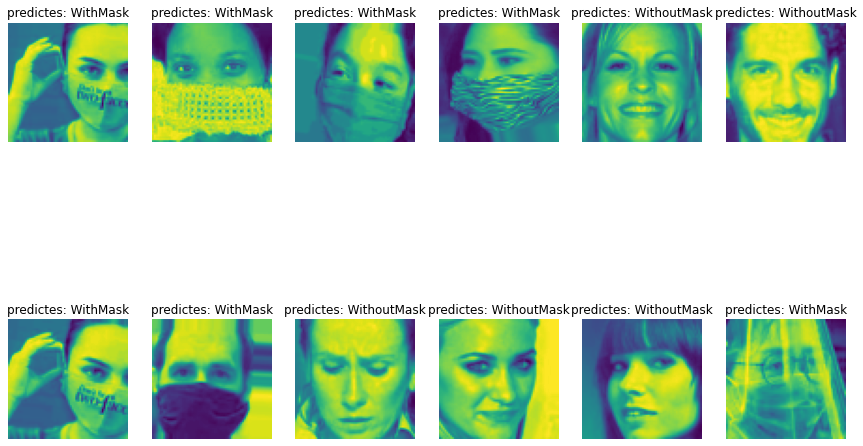

In [46]:
def visualize_model(net, num_images=12):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader1):

        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if use_cuda else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j][0,:,:])
            #imshow(torchvision.utils.make_grid(torch.reshape(inputs[j], ([64, 64, 3]))))
            #imshow(torchvision.utils.make_grid(inputs[j]))
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()